# Bernoulli mixture model

In [1]:
from jax import numpy as jnp
from cv.unsupervised import BMM

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

from matplotlib import pyplot as plt

EM-алгоритм є достатньо потужним методом максимізації правдоподібності, який має велику кількість можливих застосувань, у тому числі для кластерізації зображень. У даному прикладі ми розглянемо модель суміші розподілів Бернуллі для чорно-білих зображень з датасету MNIST. Тож спочатку завантажимо його.

In [2]:
X, target = fetch_openml('mnist_784', return_X_y=True, as_frame=False)

У даному датасеті кожен піксель є 8-бітним та представлений цілим числом від 0 до 255. Тож знормуємо їх до інтервалу $[0, 1]$. А вже після до бінарного вигляду, де 0 будуть представлені пікселі, які набули значення 0, а 1 - відповідно усі інші.

Зауважу, що спочатку ми будемо працювати тільки з зоображеннями 2 цифр, а саме 0 та 1.

In [3]:
mask = (target == '0') | (target == '1')
data = jnp.where((X[mask] / 255) > 0, 1, 0)
y = target[mask].astype('int')

EM-алгоритм дозволяє не тільки кластерізувати існуючий датасет, а й робити висновки про те, до якого кластеру належать нові спостереження. Тож розіб'ємо наш набір даних на множину для навчання та тесту.

In [4]:
data_train, data_test, y_train, y_test = train_test_split(data, y,
                                                          train_size=0.8, 
                                                          random_state=42, 
                                                          stratify=y)


$K$ - кластери. На початку ми будемо мати справу з випадком $\{0, 1\}$. 
$X = \mathrm{\{0,1\}^{h \times w}}$ - множина усіх можливих бінарних зображень. 
Кожному кластеру $k$ будемо ставити у відповідність багатовимірний розподіл з незалежними компонентами, де кожна компонента $ \sim Bernoulli(\pi_{i}^{(k)}), \pi_{i}^{(k)} \in [0,1] $, $i \in \{1, \dots, h\times w\}$

На початковому етапі ініціалізуємо параметри розподілів для усіх класів та пікселів та ймовірності кластерів з рівномірного розподілу на $[0, 1]$(додатково знормуємо ймовірності кластерів).

**E-step:**

$k \in K$,  $x^{(n)} \in X$, $x_i^{(n)} \in \{0, 1\}$ - значення $i$-ого пікселя(лінеарізована/flatten індексація) у зображенні з номером $n$

На цьому кроці ми повинні здійснити такі розрахунки.
$$ p(k|x^{(n)}) = \frac{p(k)p(x^{(n)}|k)}{\sum\limits_{g \in K} p(g)p(x^{(n)}|g)} $$

У нашому випадку ми вважаємо незалежними пікселі картинки, тому вираз набуває наступного вигляду.
$$ p(k|x^{(n)}) = 
\frac{p(k) \prod\limits_{i=1}^{h \times w} p(x_{i}^{(n)}|k)^{x_{i}^{(n)}} (1-p(x_{i}^{(n)}|k))^{1-x_{i}^{(n)}} }{\sum\limits_{g \in K} \left[ p(g) \prod\limits_{i=1}^{h \times w} p(x_{i}^{(n)}|g)^{x_{i}^{(n)}} (1-p(x_{i}^{(n)}|g))^{1-x_{i}^{(n)}} \right] } = 
\frac{1}{\sum\limits_{g \in K} \left[ \frac{p(g)}{p(k)}\prod\limits_{i=1}^{h \times w} \left( \frac{p(x_{i}^{(n)}|g)}{p(x_{i}^{(n)}|k)} \right)^{x_{i}^{(n)}} \left( \frac{1-p(x_{i}^{(n)}|g)}{1-p(x_{i}^{(n)}|k)} \right)^{1-x_{i}^{(n)}} \right] } $$
Останнє перетворення було здійснено тому що при множенні великої кількості чисел від 0 до 1 може виникнути проблема машинного нуля.

Тож остаточний вираз для випадку розподілу Бернуллі має вигляд.
$$ p(k|x^{(n)}) = 
\frac{1}{\sum\limits_{g \in K} \left[ \frac{p(g)}{p(k)}\prod\limits_{i=1}^{h \times w} \left( \frac{\pi_{i}^{(g)}}{\pi_{i}^{(k)}} \right)^{x_{i}^{(n)}} \left( \frac{1-\pi_{i}^{(g)}}{1-\pi_{i}^{(k)}} \right)^{1-x_{i}^{(n)}} \right] } $$

Для уникнення ділення на 0 будемо обмежувати значення параметрів $\pi_{i}^{(k)}$ у межах $[\varepsilon, 1-\varepsilon]$, де $\varepsilon \in (0,1)$ - параметр алгоритма.

Якщо постане задача віднести новий об'єкт до якогось з кластерів, ми будемо виконувати лише цей крок алгоритму та вказувати на  кластер з найбільшою умовною ймовірністю.

**M-step:**

$$ \sum\limits_{n=1}^{N} \sum\limits_{k \in K} p(k|x^{(n)}) \ln p(x^{(n)}|k) =
\sum\limits_{n=1}^{N} \sum\limits_{k \in K} \left[ p(k|x^{(n)}) \left( \sum\limits_{i=1}^{h \times w} x_i^{(n)}\ln \pi_{i}^{(k)} + \left( 1-x_i^{(n)} \right) \ln \left( 1-\pi_{i}^{(k)} \right) \right) \right] $$
Змінимо перші дві суми місцями(використаємо комутативність додавання) і отримаємо задачу максимізації для нашої моделі.
$$ \sum\limits_{k \in K} \sum\limits_{n=1}^{N} \left[ p(k|x^{(n)}) \left( \sum\limits_{i=1}^{h \times w} x_i^{(n)}\ln\pi_{i}^{(k)} + \left( 1-x_i^{(n)} \right) \ln\left( 1-\pi_{i}^{(k)} \right) \right) \right] \rightarrow \max\limits_{\pi_{i}^{(k)}} $$
Зважаючи на те, що доданки, що входять у суму по $k$ незалежні, ми можемо максимізувати окремо кожний з них. Тому для $\forall k \in K$ візьмемо похідну по параметрам розподілу і прирівняємо її до 0. Таким чином отрамаємо вирази для обрахунку нових параметрів.
$$ \sum\limits_{n=1}^{N} \left[ p(k|x^{(n)}) \left( \sum\limits_{i=1}^{h \times w} \frac{x_i^{(n)}}{\pi_{i}^{(k)}} + \frac{1-x_i^{(n)}}{1-\pi_{i}^{(k)}} \right) \right] = 0 \Rightarrow
\pi_{i}^{(k)} = \frac{\sum\limits_{n=1}^{N} p(k|x^{(n)}) x^{(n)}_i }{\sum\limits_{i=1}^{N} p(k|x^{(i)})} $$

Обрахунок нових ймовірностей кластерів залишається без змін(відносно лекційного матеріалу)
$$ p(k) = \frac{\sum\limits_{n=1}^{N} p(k|x^{(n)})}{N} $$

Усі ці розрахунки вже імплементовані у классі BMM, тож використаємо його.

In [5]:
bmm = BMM(2)
pred_train = bmm.fit_predict(data_train, ret_proba=True)

Зауважимо, що процес призначення до певного кластеру грунтується на схожості даних та розподілу кожного з кластерів. У випадку нашої моделі, параметри розподулу взагалі можна інтерпретувати як "узагальнені образи" зображень з кластера. Тож зобразимо їх для кожного з кластерів.

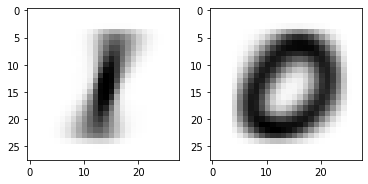

In [6]:
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(bmm.dist_params[i].reshape(28,28), cmap='gray_r')

Тепер обрахуємо метрики якость кластерізації, беручи до уваги те, що справжня наша задача була класифікувати зображення на 2 класи. Грунтуючись на цьому будемо обраховувати 2 метрики: ROC AUC і accuracy.

In [7]:
y_train = 1 - y_train #because first cluster is 1
print(f"ROC AUC Train: {roc_auc_score(y_train, pred_train[1])}")
print(f"Accuracy Train: {accuracy_score(y_train, pred_train.argmax(0))}")

ROC AUC Train: 0.9980313160674862
Accuracy Train: 0.9949255751014885


In [8]:
pred_test = bmm.predict(data_test, ret_proba=True)

y_test = 1 - y_test
print(f"ROC AUC Test: {roc_auc_score(y_test, pred_test[1])}")
print(f"Accuracy Test: {accuracy_score(y_test, pred_test.argmax(0))}") 

ROC AUC Test: 0.9972872199809202
Accuracy Test: 0.9949255751014885


Подивимось на цифри, які були віднесені до неправильного кластеру у навчальній та тестовій множині

In [9]:
def plot_fail(y_true, pred, data):
    fail_idx = jnp.argwhere(pred ^ y_true)
    N = fail_idx.shape[0]
    print(f"Fail count: {N}")

    plt.figure(figsize=(20, 4 * N // 5))

    for i, idx in enumerate(fail_idx):
        r = (N % 5 > 1)
        plt.subplot(N // 5 + r, 5, i+1)
        plt.imshow(data[idx].reshape(28,28), cmap='gray_r')

Fail count: 60


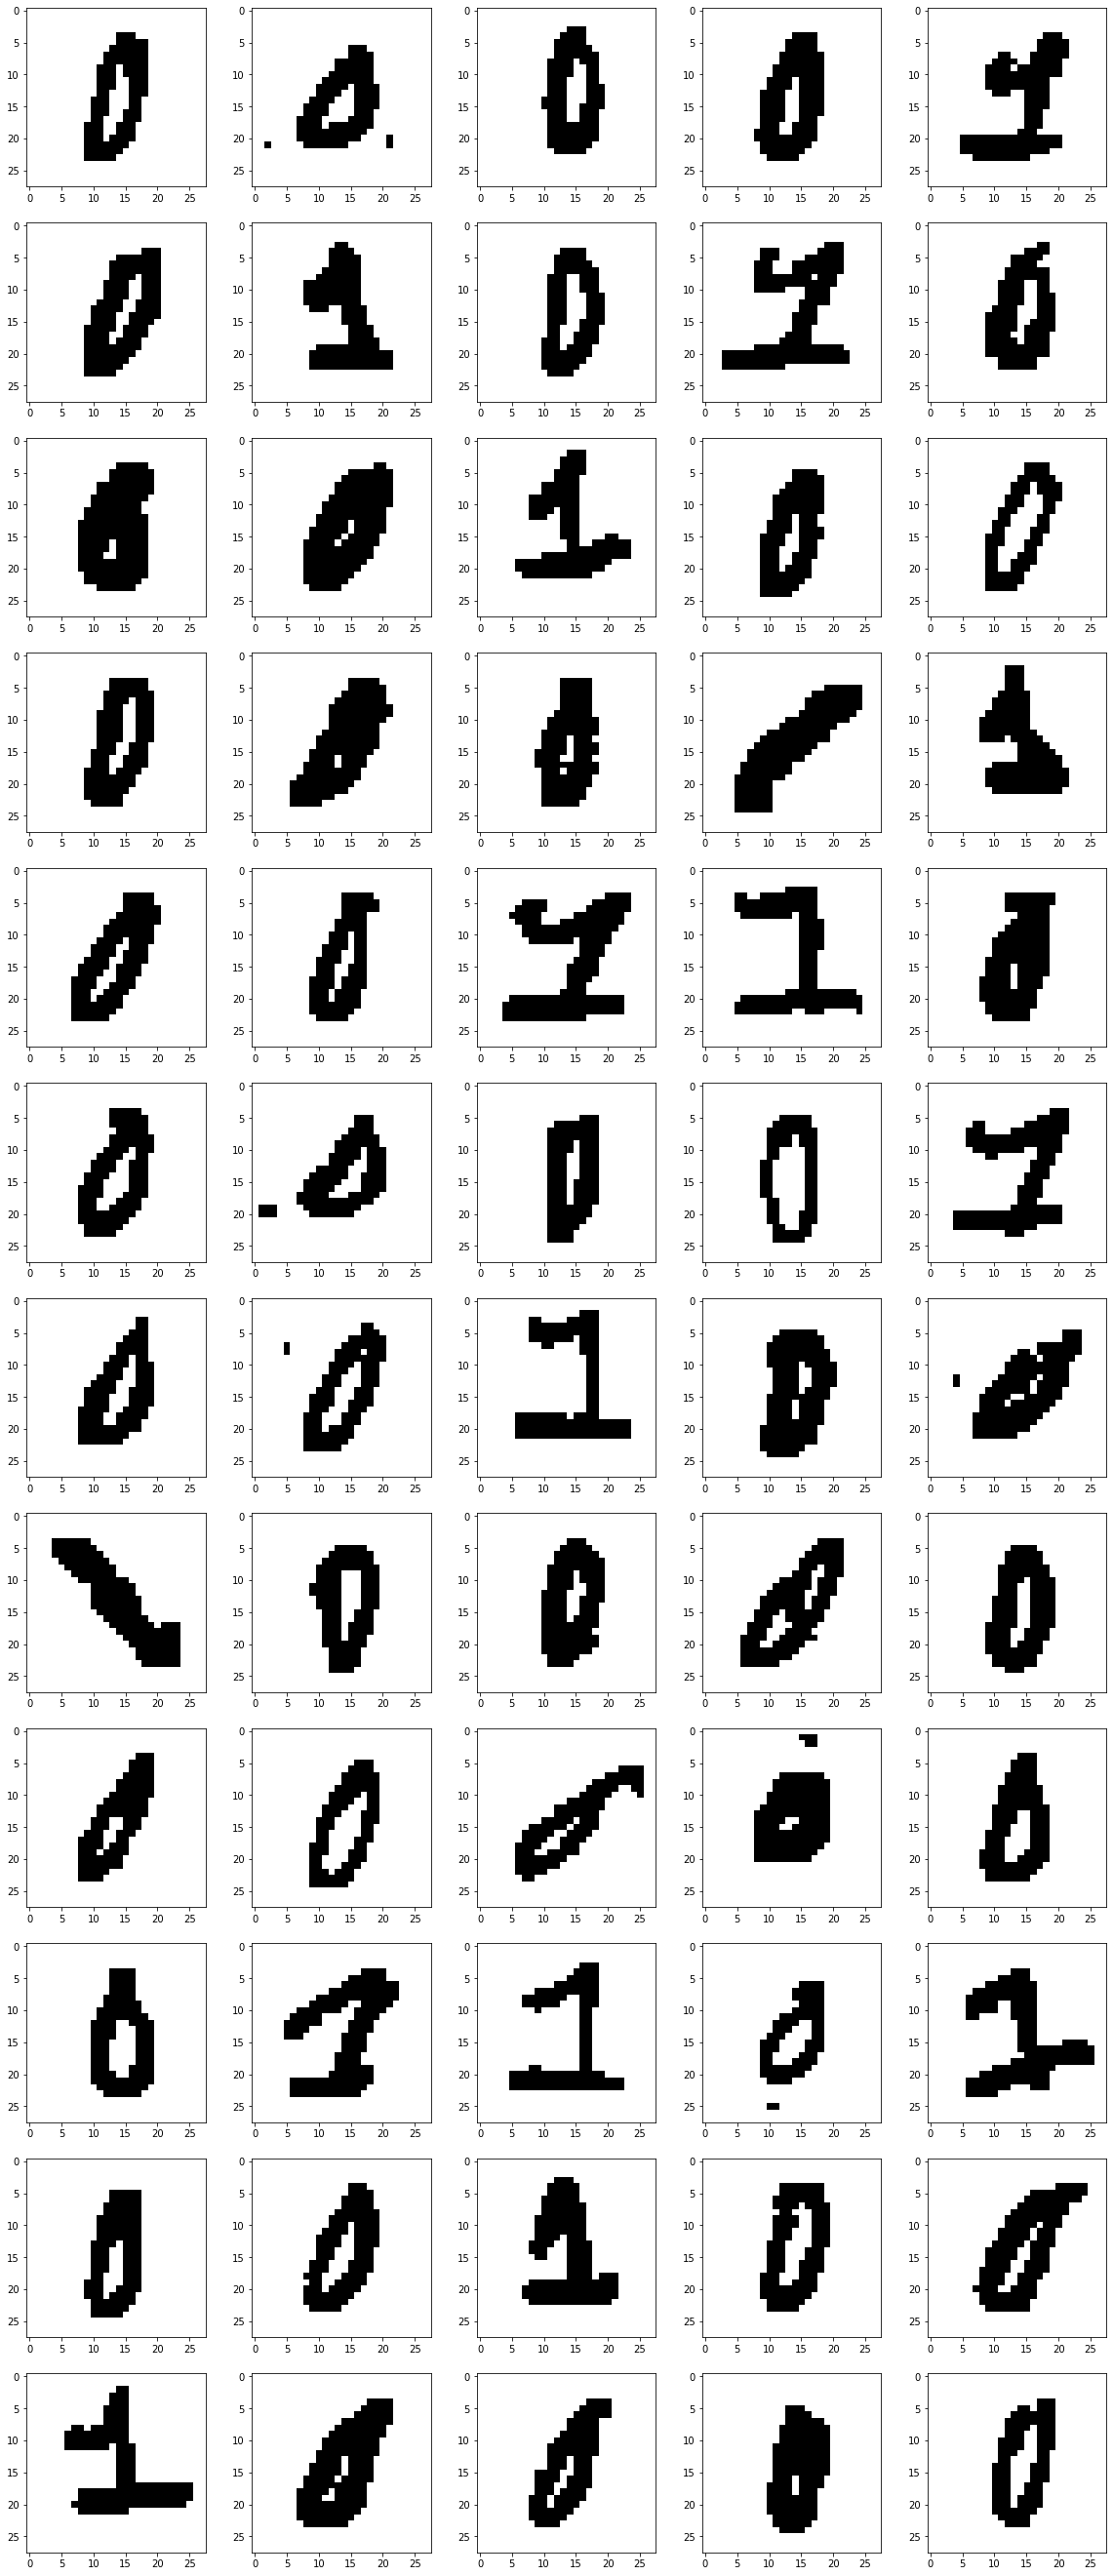

In [10]:
plot_fail(y_train, pred_train.argmax(0), data_train)

Fail count: 15


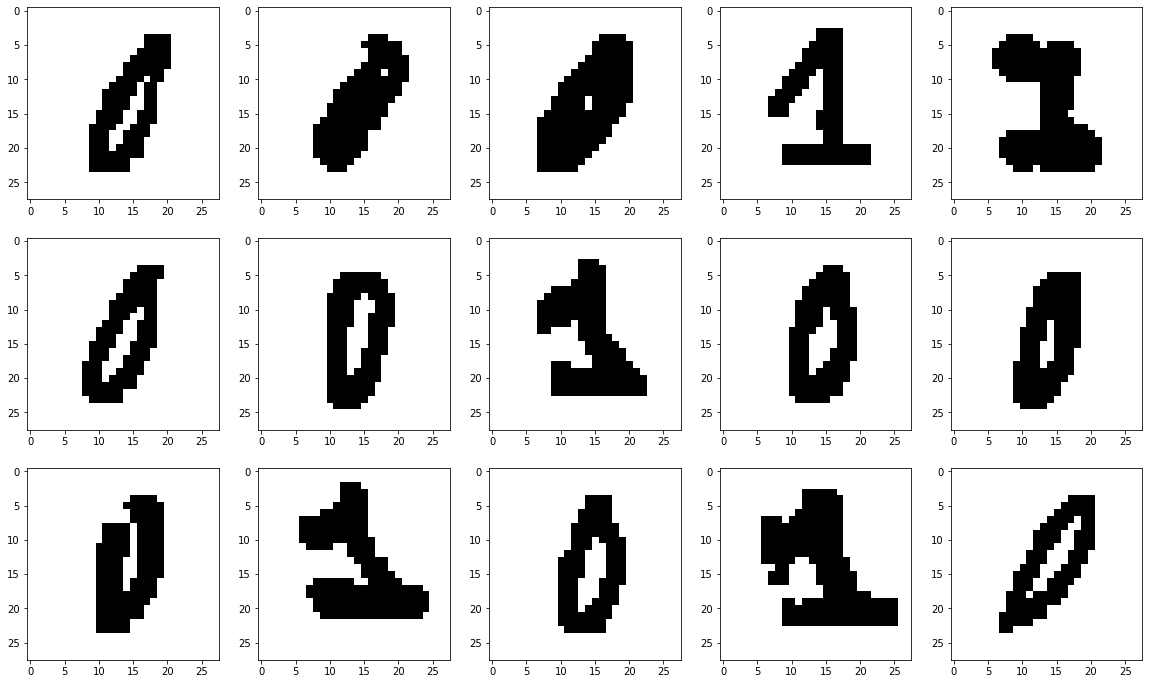

In [11]:
plot_fail(y_test, pred_test.argmax(0), data_test)

Як і очікувалось, цифри, які дуже відрізняються від більшості зі свого "справжнього" кластеру, були класифіковані неправильно.

На сам кінець, давайте спробуємо кластерізувати цифри 0, 1, 2 та 3 та подивитися на "узагальнені образи" кластерів.

In [12]:
mask4 = (target == '0') | (target == '1') | (target == '2') | (target == '3')
data4 = jnp.where((X[mask4] / 255) > 0, 1, 0)

bmm4 = BMM(4)
bmm4.fit_predict(data4)

DeviceArray([1, 2, 3, ..., 2, 3, 0], dtype=int32)

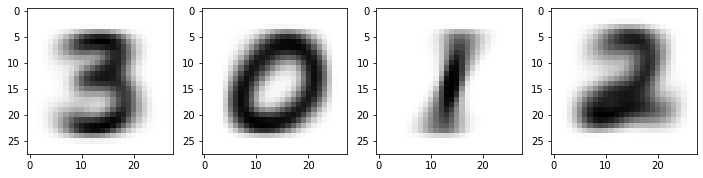

In [13]:
plt.figure(figsize=(12, 3))

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(bmm4.dist_params[i].reshape(28,28), cmap='gray_r')